# SP&500
### Base case. Study of the performance of the SP&500 in a long-term investment using the Vanguard S&P 500 ETF.

In [1]:
import yfinance as yf
import pandas as pd
import locale
import matplotlib.pyplot as plt
import requests
import numpy as np
import sys
import os

proyecto_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print("ruta: ", proyecto_dir)
sys.path.append(proyecto_dir)
# # this sets locale to the current Operating System value
locale.setlocale(locale.LC_ALL, '') 

ruta:  \\wsl.localhost\Debian\home\adal110\workspace\tfg\tfg-service


'Spanish_Spain.1252'

## Downloading the data

The Vanguard S&P 500 ETF (Exchange-Traded Fund) is an exchange-traded fund that seeks to replicate the performance of the Standard & Poor's 500 Index (S&P 500), one of the most widely followed and widely used benchmarks for the U.S. stock market.

In [2]:
voo_etf = yf.download("VOO", start="2011-01-01", end="2024-01-01", interval="1mo")
display(voo_etf)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-01,115.940002,119.220001,115.480003,117.699997,92.095169,4402150
2011-02-01,118.480003,123.220001,118.379997,121.779999,95.287567,2761400
2011-03-01,122.279999,122.300003,114.639999,121.239998,94.865074,3866600
2011-04-01,122.120003,124.879997,118.440002,124.800003,98.087906,2302350
2011-05-01,125.440002,125.440002,120.160004,123.339996,96.940384,2455100
...,...,...,...,...,...,...
2023-08-01,419.260010,420.079987,397.850006,413.829987,409.246735,87472600
2023-09-01,416.459991,416.880005,389.450012,392.700012,388.350800,85361800
2023-10-01,391.899994,402.500000,375.950012,384.170013,381.364624,112733000


## Vanguard S&P 500 Dividends

In [3]:
dividend_history = yf.Ticker("VOO").dividends
print(dividend_history)

Date
2010-09-24 00:00:00-04:00    0.558
2010-12-27 00:00:00-05:00    0.526
2011-03-25 00:00:00-04:00    0.536
2011-06-24 00:00:00-04:00    0.570
2011-09-23 00:00:00-04:00    0.580
2011-12-23 00:00:00-05:00    0.686
2012-03-26 00:00:00-04:00    0.570
2012-06-25 00:00:00-04:00    0.640
2012-09-24 00:00:00-04:00    0.686
2012-12-24 00:00:00-05:00    0.940
2013-03-22 00:00:00-04:00    0.670
2013-06-24 00:00:00-04:00    0.738
2013-09-23 00:00:00-04:00    0.786
2013-12-24 00:00:00-05:00    0.914
2014-03-24 00:00:00-04:00    0.779
2014-06-23 00:00:00-04:00    0.809
2014-09-22 00:00:00-04:00    0.876
2015-03-23 00:00:00-04:00    0.984
2015-06-22 00:00:00-04:00    0.902
2015-09-21 00:00:00-04:00    0.953
2015-12-21 00:00:00-05:00    1.092
2016-03-21 00:00:00-04:00    1.006
2016-06-21 00:00:00-04:00    0.953
2016-09-13 00:00:00-04:00    0.883
2016-12-22 00:00:00-05:00    1.296
2017-03-22 00:00:00-04:00    0.998
2017-06-23 00:00:00-04:00    1.010
2017-09-20 00:00:00-04:00    1.176
2017-12-26 00:0

c:\Users\adald\anaconda3\envs\notebook\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


## Historical cpi data
The data was taking by the Bureau of Labor Statistics. 

The Consumer Price Index (CPI) is a measure used to calculate the average change in prices of a basket of goods and services that consumers typically purchase, such as food, housing, transportation, health care and other common products and services.
The CPI is a key tool for measuring inflation in an economy. When the CPI rises, it indicates that prices are generally rising, which is interpreted as inflation.

## Profit

The profit within an ETF are given by two factors:

1. Revaluation of underlying assets: If an ETF invests in stocks, bonds or other assets, gains may come from the revaluation of those assets.

2. Dividends. Dividends are portions of the profits that a company generates and distributes to its shareholders. If the ETF invests in dividend-paying stocks, gains may be derived from dividend payments received on those stocks.

3. If the ETF invests in bonds or other fixed income instruments, gains may be derived from interest earned on those bonds. Interest is distributed periodically to ETF investors in the form of interest payments.

Equity ETFs, such as the Vanguard S&P 500 ETF, do not typically earn interest directly, as they invest primarily in equities.

## Costs
When investing we have to take into account a series of costs:
Maintenance fee: A fee charged for the maintenance of your investment account, typically on a regular basis (e.g., monthly or annually).

* **Depository fee:** A fee charged by the depository institution responsible for holding and safeguarding your securities within your investment account.
* **Securities custody fee:** A fee charged for the safekeeping and custody of your securities within your investment account.
* **Inactivity fee:** A fee charged when there is no activity or insufficient activity in your investment account over a certain period of time.
* **Dividend collection fee:** A fee charged for the collection and processing of dividends paid out by the securities held within your investment account.
* **Currency exchange fee:** A fee charged for converting one currency to another, often applied when trading securities denominated in a currency different from your account's base currency.
* **Buy/sell commission:** A fee charged for executing buy or sell orders of securities within your investment account.
* **Securities transfer fee:** A fee charged for transferring securities from one investment account to another, typically when moving assets between different financial institutions.
* **Taxes:** Taxes payable after earning our profits

## Plataform
Let's invest in the S&P 500 vanguard from myInvestor

Why invest with myInvestor? There are many investment platforms, online brokers or banks that we can use to invest, but we chose myInvestor for these reasons:
1. **Low costs:** Buying and selling commission of 0.12% with no minimum investment and 0.30% currency exchange rate.
2. **Security:** Savings are guaranteed by the Spanish Deposit Guarantee Fund, provided for in Royal Decree 16/2011, October 14. It covers up to €100,000 per account and holder.
3. **No minimum investment in each operation:** Can be adapted to various investment profiles

In [4]:
buySell_comission = 0.12
current_exchange_rate = 0.30
comission = buySell_comission + current_exchange_rate

## Initial variables

In [5]:
api_key = 'd452de1977364817904402ad0ed7546d'
base_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
series_id = 'CUUR0000SA0'
start_year = '2011'
end_year = '2023'
url = f"{base_url}{series_id}?startyear={start_year}&endyear={end_year}&registrationkey={api_key}"

In [6]:
from app.services.metrics_lib import Metrics
name = "Vanguard SP500 ETF"
description = "Performance of the SP500 in a long-term investment using the Vanguard SP500 ETF"
model = "Vanguard_SP500_ETF"
initial_capital = 1000
monthly_contribution = 100
profile_id = 2
strategy_id = 57
m = Metrics(initial_capital, monthly_contribution, profile_id, strategy_id, comission)
m.InitStrategy(name, description, model)

The object already exists in the JSON file.


## Annual inflation rate

In [7]:
annual_inflation = m.AnnualInflation(url)
display(annual_inflation)

,cpi_start,cpi_end,inflation_rate
date,,,
2011,220.223,225.672,2.474310
2012,226.665,229.601,1.295304
2013,230.280,233.049,1.202449
2014,233.916,234.812,0.383043
2015,233.707,236.525,1.205783
2016,236.916,241.432,1.906161
2017,242.839,246.524,1.517466
2018,247.867,251.233,1.357986
2019,251.712,256.974,2.090484


## Metrics
Calculation of different metrics for strategy evaluation. Before calculating the metrics we will divide the data into 3 timelines to ensure that the outcome of the data is not manipulated by market conditions at a point in time.

In [8]:
# Vanguard S&P 500 data
sp500_df1 = voo_etf.loc[:'2014-12-01']
sp500_df1.index = pd.to_datetime(sp500_df1.index)
sp500_df2 = voo_etf.loc['2015-01-01':'2018-12-01']
sp500_df2.index = pd.to_datetime(sp500_df2.index)
sp500_df3 = voo_etf.loc['2019-01-01':]
sp500_df3.index = pd.to_datetime(sp500_df3.index)

# Dividens SP500 data
dividends_df1 = dividend_history.loc[:'2014-12-31']
dividends_df1.index = pd.to_datetime(dividends_df1.index)
dividends_df2 = dividend_history.loc['2015-01-01':'2018-12-31']
dividends_df2.index = pd.to_datetime(dividends_df2.index)
dividends_df3 = dividend_history.loc['2019-01-01':]
dividends_df3.index = pd.to_datetime(dividends_df3.index)


In [9]:
# The three timeline
df_timeline_df1 = m.joinDataAndDividends(sp500_df1, dividends_df1)
df_timeline_df2 = m.joinDataAndDividends(sp500_df2, dividends_df2)
df_timeline_df3 = m.joinDataAndDividends(sp500_df3, dividends_df3)
df_timelines = [df_timeline_df1, df_timeline_df2, df_timeline_df3]

\\wsl.localhost\Debian\home\adal110\workspace\tfg\tfg-service\app\services\metrics_lib.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year_Month'] = data.index.to_period('M')
\\wsl.localhost\Debian\home\adal110\workspace\tfg\tfg-service\app\services\metrics_lib.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year_Month'] = data.index.to_period('M')
\\wsl.localhost\Debian\home\adal110\workspace\tfg\tfg-service\app\services\metrics_lib.py:58: SettingWithCopyWarning: 
A value is trying t

### Example of timeline

In [10]:
display(df_timeline_df1)

,Open,High,Low,Close,Adj Close,Volume,Date,Dividends
0,115.940002,119.220001,115.480003,117.699997,92.095169,4402150,2011-01,NaN
1,118.480003,123.220001,118.379997,121.779999,95.287567,2761400,2011-02,NaN
2,122.279999,122.300003,114.639999,121.239998,94.865074,3866600,2011-03,0.536
3,122.120003,124.879997,118.440002,124.800003,98.087906,2302350,2011-04,NaN
4,125.440002,125.440002,120.160004,123.339996,96.940384,2455100,2011-05,NaN
5,123.040001,123.040001,115.540001,120.680000,94.849716,2549750,2011-06,0.570
6,120.739998,124.099998,117.440002,118.199997,93.351990,2977450,2011-07,NaN
7,119.779999,119.820000,100.919998,111.680000,88.202629,9424800,2011-08,NaN
8,111.739998,112.800003,102.379997,103.519997,81.758041,4571000,2011-09,0.580
9,102.820000,118.300003,98.239998,114.639999,91.049263,8390200,2011-10,NaN


### Total Return
Measures the total return generated by the strategy during the backtesting period. It is calculated as the percentage change in the value of the portfolio between the beginning and the end of the period.

In [11]:
## This method calculate the total return of one active
def TotalReturn(df_timeline, period, initial_capital=initial_capital):
  if (initial_capital is None): initial_capital = initial_capital
  operations = pd.DataFrame(columns=['Asset', 'Date', 'Type', 'Amount', 'Price', 'Total','Period'])
  total_return = initial_capital - (initial_capital * comission / 100)
  for _, row in df_timeline.iterrows():
    # Prive movement. 1 -> 100% and -1 -> -100%
    movement = (row['Close'] - row['Open']) / row['Open']
    total_return += total_return * movement
    total_return += monthly_contribution - (monthly_contribution * comission / 100)
    if not pd.isna(row['Dividends']):
      total_return += total_return * row['Dividends'] / 100 
    # Operation
    operations.loc[len(operations)] = {
      'Asset': 'SP&500',
      'Date': row['Date'],
      'Type': 'Buy',
      'Amount': monthly_contribution,
      'Price': row['Open'],
      'Total': total_return,
      'Period': period
    }
    m.CreateOperation(
      'SP&500',
      str(row['Date']),
      'Buy',
      monthly_contribution,
      str(row['Open']),
      total_return, 
      period
    )
  return {
    'total': total_return,
    'operations': operations
  }

In [12]:
data = []
total_returns = []
for index, df_timeline in enumerate(df_timelines):
  period = 'period_' + str(index + 1)
  total = TotalReturn(df_timeline, period)
  data.append(total)
  total_returns.append(total['total'])

### Total return in each timeline

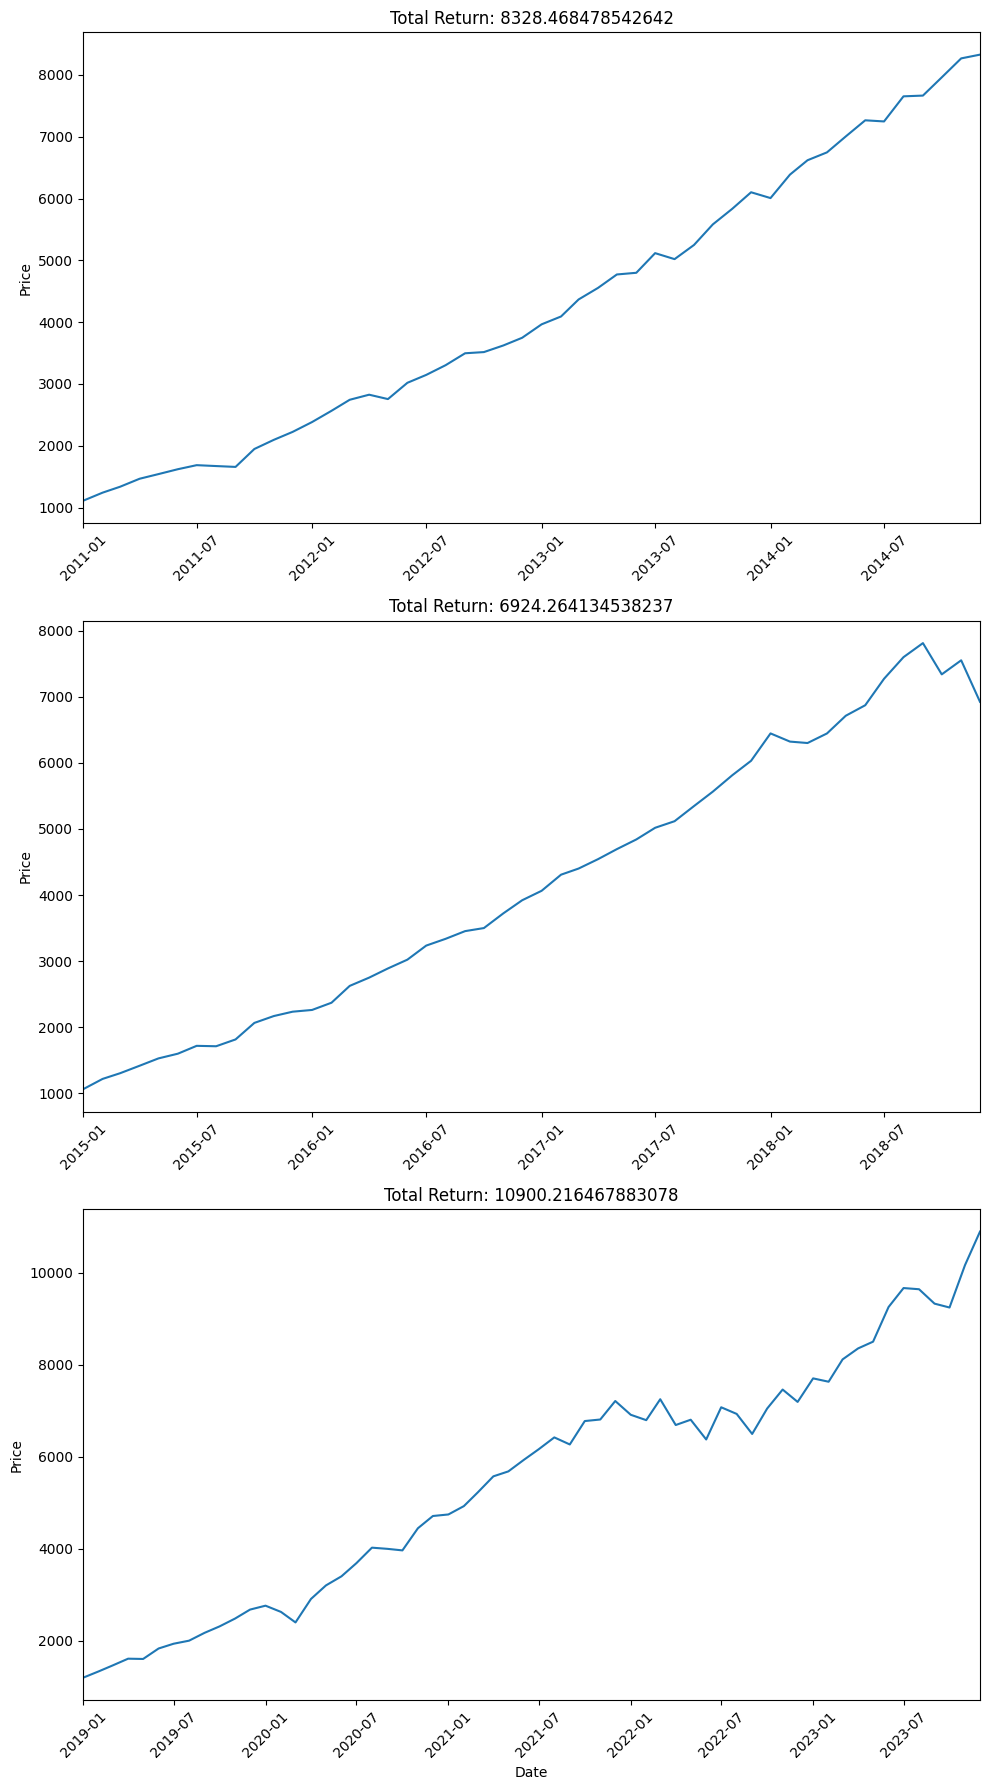

In [13]:
m.ShowTimelineTotalReturn(data)

### Total return value

In [14]:
total_values = [item['total'] for item in data]
total_return_mean = np.mean(total_values)
print('Total return mean: ', total_return_mean)

Total return mean:  8717.649693654652


## Comparison between saving money and investing it in the Vanguard sp500

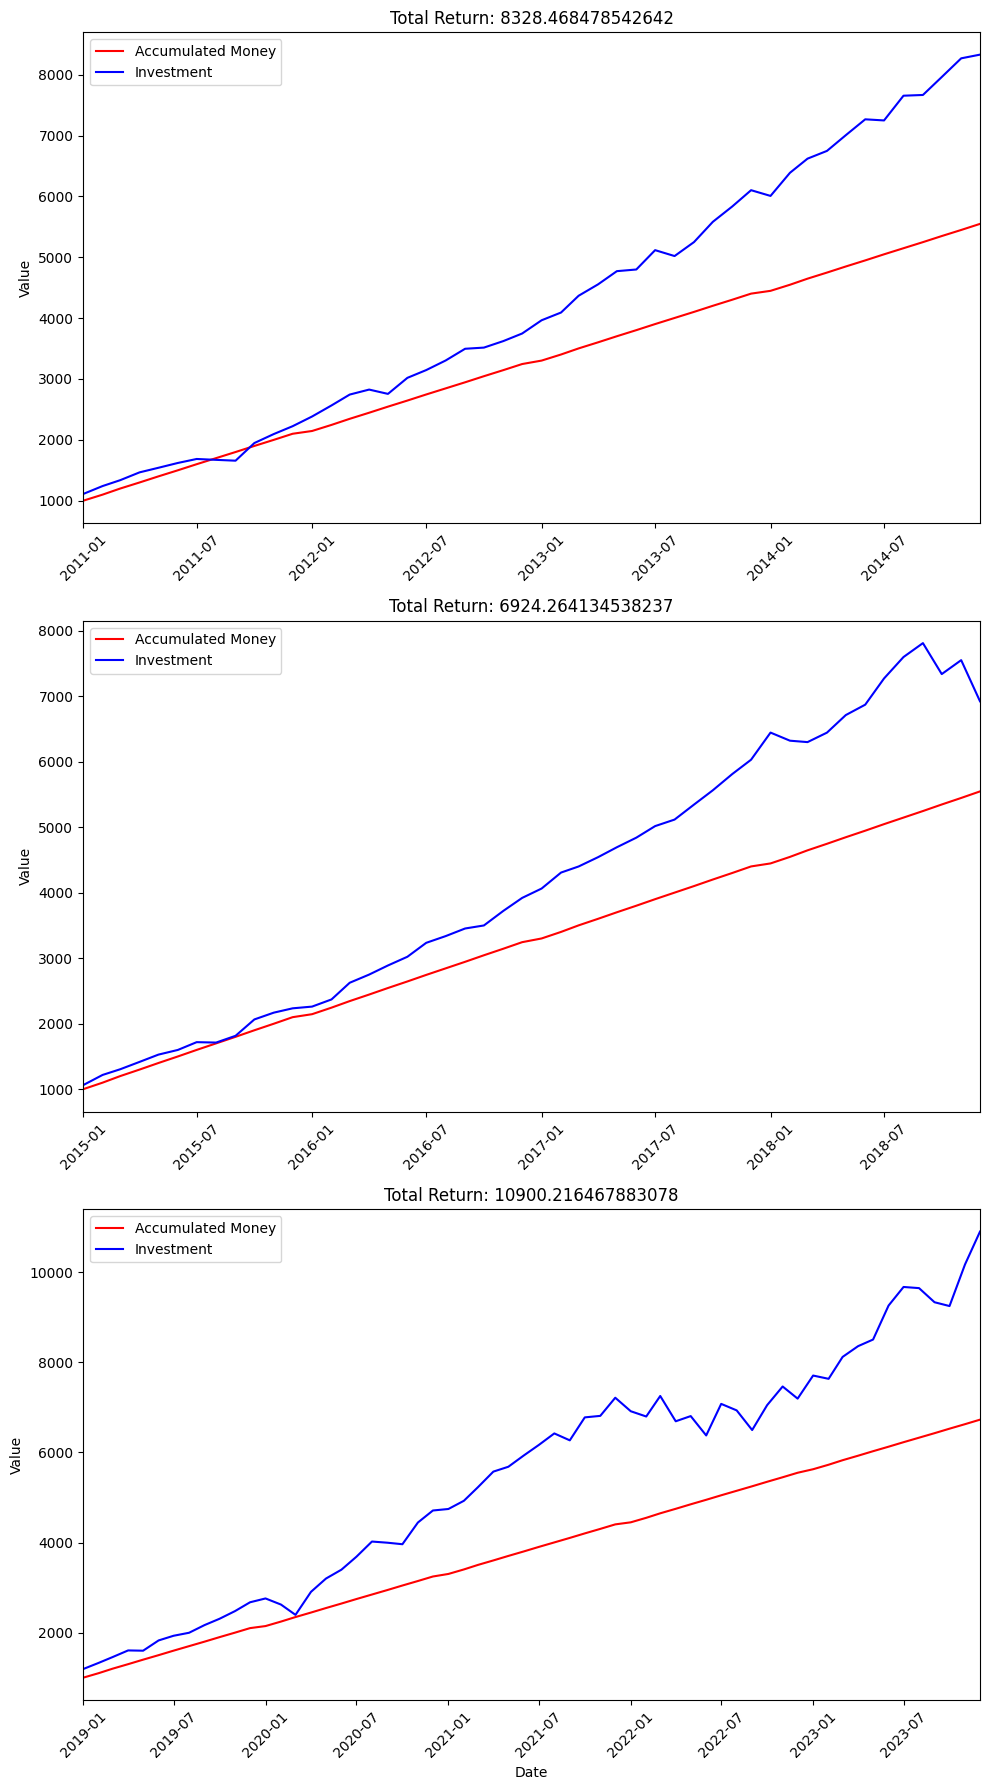

In [15]:
m.showComparisonBetweenActiveAndSavings(data, annual_inflation, start_year)

## Annualized Return 
Provides a view of the average return per year. This is important for comparing strategies over different time periods

In [16]:
 ## This method calculate the annualized return of one active
def AnnualizedReturn(df, start_year, end_year, period):
  total_annual_profit = []
  capital = initial_capital + monthly_contribution * 12
  for year in range(start_year, end_year + 1):
    filtered_data = df.loc[df['Date'].dt.year == year]
    total_return_after_one_year = TotalReturn(filtered_data, period, capital)
    capital += monthly_contribution * 12
    variation = (total_return_after_one_year['total'] - capital) / capital * 100
    capital = total_return_after_one_year['total']
    total_annual_profit.append({
      'year': year,
      'variation': variation
    })
  return total_annual_profit

In [17]:
annual_returns_df1 = AnnualizedReturn(df_timeline_df1, 2011, 2014, 'period_1')
annual_returns_df2 = AnnualizedReturn(df_timeline_df2, 2015, 2018, 'period_2')
annual_returns_df3 = AnnualizedReturn(df_timeline_df3, 2019, 2023, 'period_3')

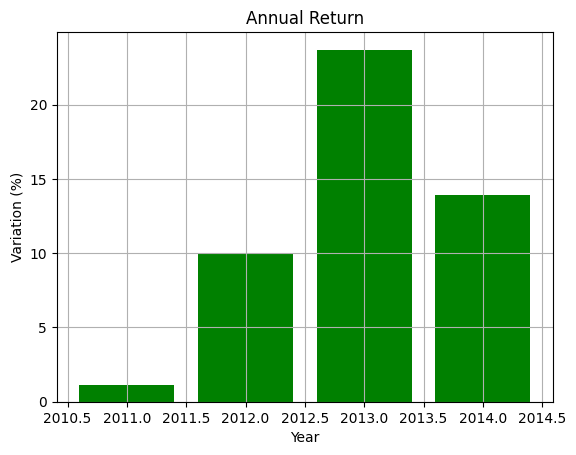

Mean annualize return:  12.162030400186211


In [18]:
m.AnnualizadReturnGraphic(annual_returns_df1)
print('Mean annualize return: ', m.MeanAnnualizedReturn(annual_returns_df1))

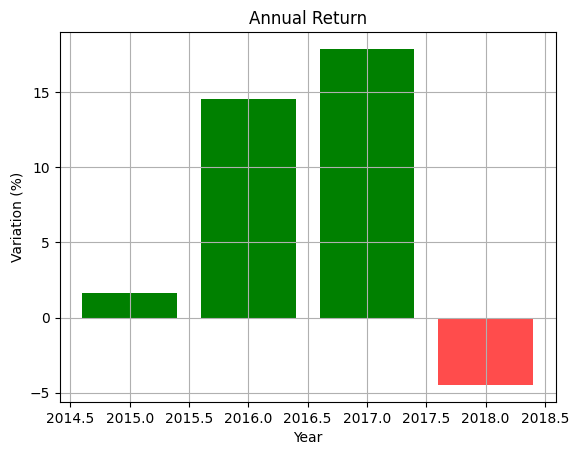

Mean annualize return:  7.383140247428172


In [19]:
m.AnnualizadReturnGraphic(annual_returns_df2)
print('Mean annualize return: ', m.MeanAnnualizedReturn(annual_returns_df2))

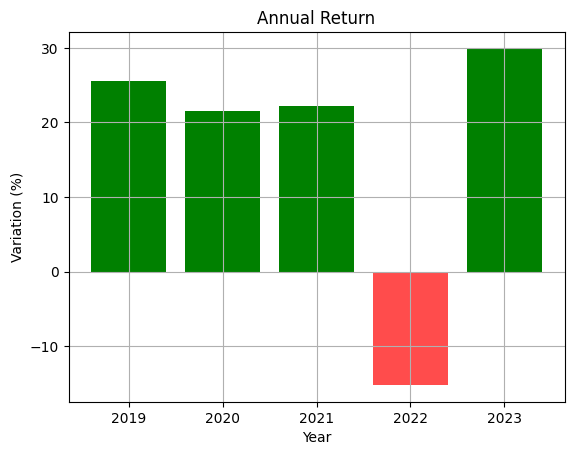

Mean annualize return:  16.793505653497512


In [20]:
m.AnnualizadReturnGraphic(annual_returns_df3)
print('Mean annualize return: ', m.MeanAnnualizedReturn(annual_returns_df3))

### Mean Annualized Return

In [21]:
annualized_return = [m.MeanAnnualizedReturn(annual_returns_df1), m.MeanAnnualizedReturn(annual_returns_df2), m.MeanAnnualizedReturn(annual_returns_df3)]
print("Total mean annualized return: ", np.mean(annualized_return))

Total mean annualized return:  12.112892100370631


## Volatility 
Measures the degree of variation in the strategy's returns, which provides an idea of the associated risk. Higher volatility implies higher risk.

In [22]:
names = ["df_timeline_df1", "df_timeline_df2", "df_timeline_df3"]
array_volatility = []
array_volatility, volatility_values  = m.CalculateVolatility(data, names)

In [23]:
df_volatility = pd.DataFrame(array_volatility)
display(df_volatility)

,name,volatility (%)
0,df_timeline_df1,3.696062
1,df_timeline_df2,3.937063
2,df_timeline_df3,5.862710


In [24]:
print(len(m.experatedGrowRateValues(m.MeanAnnualizedReturn(annual_returns_df1), 4)))

48


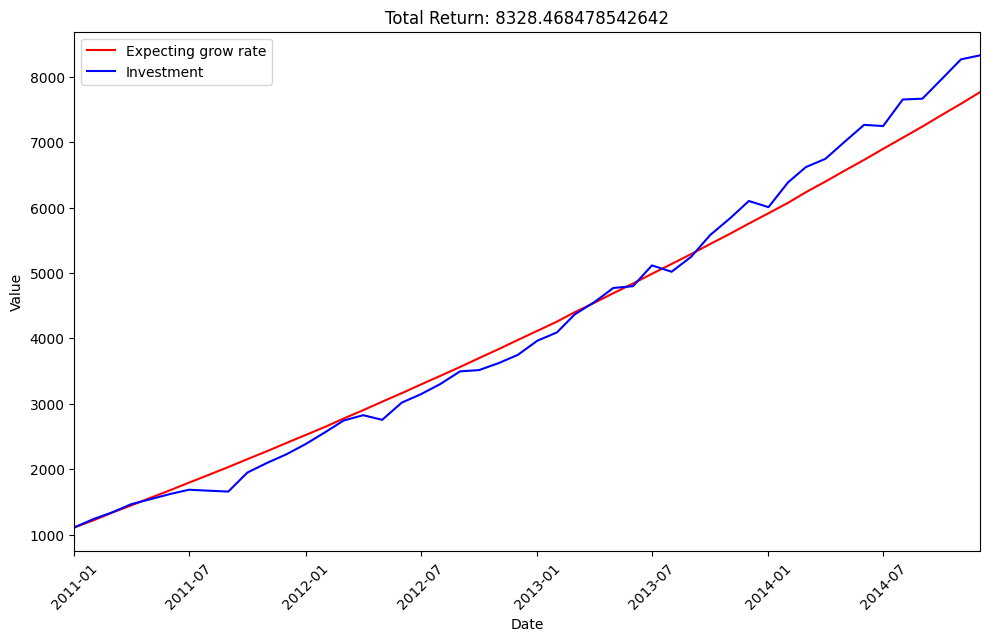

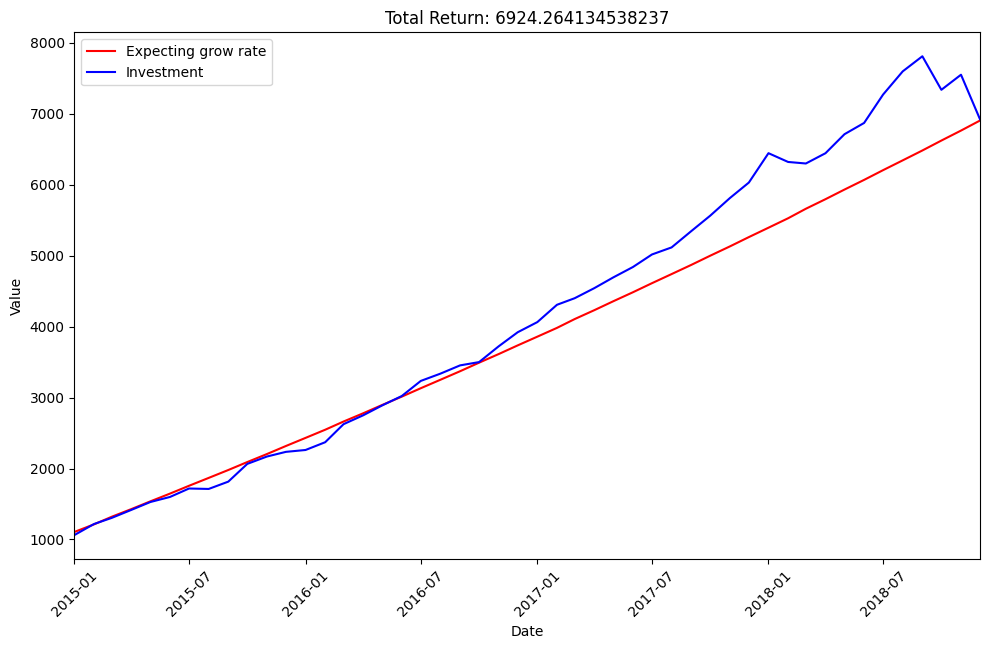

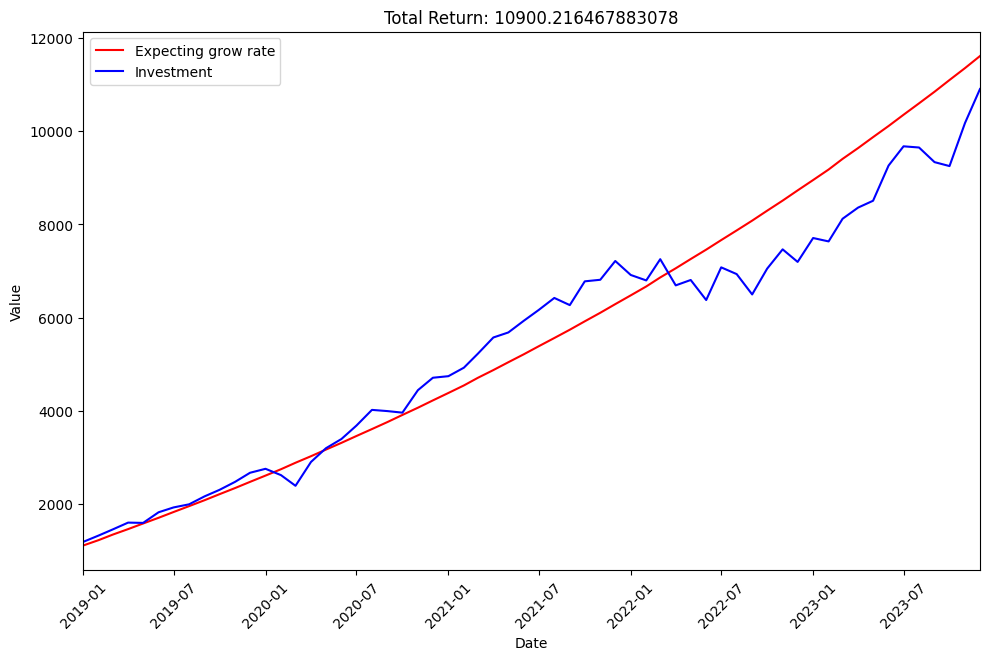

In [25]:
m.showScatterPlot(0, annual_returns_df1, 4, data)
m.showScatterPlot(1, annual_returns_df2, 4, data)
m.showScatterPlot(2, annual_returns_df3, 5, data)

## Maximum Loss
It is the largest drop from a peak to a trough in the portfolio value during the backtesting period. It indicates the maximum risk an investor would have faced.

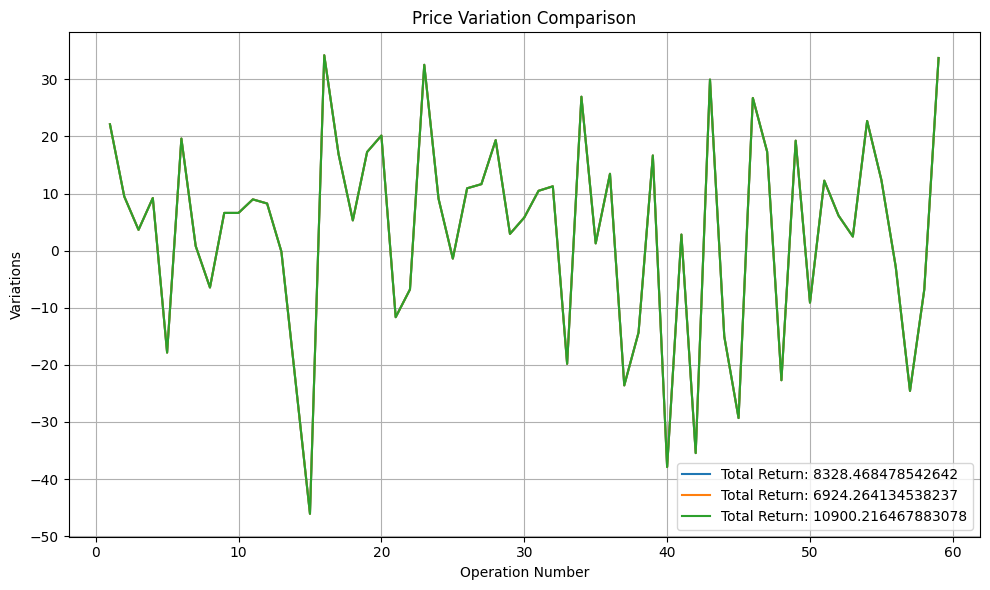

In [26]:
price_diff, max_loss_values = m.CalculateMaximunLoss(data)
m.showMaximunLossGraphic(data, price_diff)

In [27]:
names = ["df_timeline_df1", "df_timeline_df2", "df_timeline_df3"]
m.displayMaximunLossDataFrame(names, data, max_loss_values)

,name,maximun_loss (%)
0,df_timeline_df1,-9.620003
1,df_timeline_df2,-18.829987
2,df_timeline_df3,-46.080002


Average maximum loss:  -24.84333038330078


## Sharpe Ratio
Compares the return earned in excess of the risk-free yield (such as government bonds) with respect to volatility:

* **Less than 1:** This indicates that the investment return is less than the risk-free rate, suggesting that the investor could have earned a better return by simply investing in risk-free assets, such as government bonds.
* **Around 1:** A Sharpe Ratio of around 1 suggests that the investment return adequately compensates for the risk taken. This is an acceptable balance between risk and return.
* **More than 1:** A Sharpe Ratio greater than 1 indicates that the investment return is higher than the risk-free rate, suggesting that the investor is being compensated for the additional risk taken.
* **Higher is better:** In general, a higher Sharpe Ratio is better because it indicates a higher return relative to risk.

In [28]:
risk_free_rate = 3

sharpe_ratio_values = [m.SharpeRatio(risk_free_rate, annualized_return[0], array_volatility[0]['volatility (%)']), 
                      m.SharpeRatio(risk_free_rate, annualized_return[1], array_volatility[1]['volatility (%)']), 
                      m.SharpeRatio(risk_free_rate, annualized_return[2], array_volatility[2]['volatility (%)'])]

m.displayRatios('Sharpe', sharpe_ratio_values)

,Period,Sharpe ratio value
0,1,2.478863
1,2,1.113302
2,3,2.352752


Sharpe ratio mean:  1.9816391165652287


## Sortino Ratio

In [29]:
sortino_ratio_values = []

for index, item in enumerate(data):
    returns = item['operations']['Total'].pct_change().dropna()
    sortino = m.SortinoRatio(returns, risk_free_rate)
    sortino_ratio_values.append(sortino)
    
m.displayRatios('Sortino', sortino_ratio_values)

,Period,Sortino ratio value
0,1,-574.850433
1,2,-199.230319
2,3,-145.342595


Sortino ratio mean:  -306.4744486298525


## Alpha and Beta 
- Alpha measures the strategy's performance compared to a benchmark index, adjusted for risk. 
- Beta measures the sensitivity of the strategy's returns to movements

In [30]:
def CalculateBetasAplhas(annualized_return, risk_free_rate, array_volatility, df_timelines, start_year, data, annual_inflation):
  betas = []
  alphas = []
  for index, strategy_return in enumerate(annualized_return):
    cov = strategy_return - risk_free_rate
    var_market = array_volatility[0]['volatility (%)'] ** 2
    beta = cov / var_market
    capital = m.CalculateAccumulatedTotalReturn(len(data[index]['operations']['Date']), start_year, annual_inflation)
    total_return = TotalReturn(df_timelines[index], f'Period {index}')['total']
    profit = (total_return - capital) / total_return * 100
    alpha = profit - (risk_free_rate + beta * (strategy_return - risk_free_rate))
    betas.append(beta)
    alphas.append(alpha)
    
  return [betas, alphas]

In [31]:
betas, alphas = CalculateBetasAplhas(annualized_return, risk_free_rate, array_volatility, df_timelines, start_year, data, annual_inflation)

m.displayRatios('Betas', betas)
m.displayRatios('Alphas', alphas)

,Period,Betas ratio value
0,1,0.670677
1,2,0.320854
2,3,1.009709


Betas ratio mean:  0.6670797440145874


,Period,Alphas ratio value
0,1,24.239235
1,2,15.468274
2,3,21.363174


Alphas ratio mean:  20.356894281503315


## Information Ratio
It compares the additional returns of a strategy with respect to a benchmark index, relative to the volatility of those additional returns.

In [32]:
def informationRatio(strategy_performance, dst_excess_perfomance):
  excess_performance = strategy_performance - risk_free_rate
  return excess_performance / dst_excess_perfomance

information_ratio_data = [
  informationRatio(m.MeanAnnualizedReturn(annual_returns_df1), array_volatility[0]['volatility (%)']),
  informationRatio(m.MeanAnnualizedReturn(annual_returns_df2), array_volatility[1]['volatility (%)']),
  informationRatio(m.MeanAnnualizedReturn(annual_returns_df3), array_volatility[2]['volatility (%)'])
]

for item in information_ratio_data:
  print(item)

2.478862805689458
1.1133021168942838
2.3527524271119438


In [33]:
print('Mean information ratio: ', np.mean(information_ratio_data))

Mean information ratio:  1.9816391165652287


## Success Rate
Percentage of winning operations compared to total operations. For our strategy, this metric does not make sense.

## Recovery Factor. 
Relates the total return to the maximum drawdown, indicating how much has been earned for each unit of risk taken. For our strategy, this metric does not make sense.

## Portfolio concentration ratios 
Indicate how diversified or concentrated the portfolio is in certain assets or sectors.

| Clase de activos    | Inversión | Categoría | Índice |
|---------------------|-----------|-----------|--------|
| Renta variable      | 100.00    | 90.40     | 100.00 |
| Renta fija          | 0.00      | 0.37      | 0.00   |
| Preferente          | 0.00      | 0.00      | 0.00   |
| Convertible         | 0.00      | 0.00      | 0.00   |
| Posiciones líquidas | 0.00      | 1.30      | 0.00   |
| Otros               | 0.00      | 15.39     | 0.00   |


| Sectores                 | Fondo cambio% | Categoría cambio% | Agrupación  |
|--------------------------|---------------|-------------------|-------------|
| Materiales Básicos       | 2.15          | 2.49              | Cíclicos    |
| Consumo Cíclico          | 10.50         | 10.62             | Cíclicos    |
| Servicios Financieros    | 12.68         | 13.38             | Sensibles   |
| Inmobiliario             | 2.28          | 2.46              | Cíclicos    |
| Servicios de Comunicación| 8.95          | 8.63              | Sensibles   |
| Energía                  | 3.95          | 3.17              | Cíclicos    |
| Industriales             | 8.32          | 8.51              | Cíclicos    |
| Tecnología               | 30.58         | 30.24             | Sensibles   |
| Consumo Defensivo        | 5.93          | 5.48              | Defensivos  |
| Salud                    | 12.45         | 13.28             | Defensivos  |
| Servicios Públicos       | 2.20          | 1.74              | Defensivos  |

In [34]:
fund_percentage_change = [
    2.15, 10.50, 12.68, 2.28, 8.95, 3.95, 8.32, 30.58, 5.93, 12.45, 2.20
]
portfolio_concentration_rate = m.CalculatePorfolioConcentratio(fund_percentage_change)

print("Portfolio Concentration Rate:", portfolio_concentration_rate)


Portfolio Concentration Rate: 75.16751675167515


## Frequency and Duration of Operations
Information on how often trades are made and how long positions are held. In our case, the trades last for the entire investment period. For our strategy, this metric does not make sense.

data = {
  'total_profitability': ,
  'volatility': ,
}

In [35]:
m.UpdateInvestmentProfileStrategy(total_returns, volatility_values, max_loss_values, sharpe_ratio_values, sortino_ratio_values, alphas, betas, information_ratio_data, 0.0, portfolio_concentration_rate)